# model 4

In [1]:
# Run development environment checks for gpu compute
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

2025-07-18 04:46:29.978776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752813990.002821  296574 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752813990.011026  296574 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752813990.030344  296574 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752813990.030386  296574 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752813990.030392  296574 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Is built with CUDA: True
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Run pip dependency fallbacks on env if needed
#!pip install "numpy<2"

In [ ]:
#!pip install xgboost

In [7]:
#!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 KB 1.5 MB/s eta 0:00:00


In [1]:
#!rm -rf ~/.cache/huggingface/datasets

In [24]:
# XGBoost CPU-only build
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['XGBOOST_FORCE_CPU'] = '1'

import numpy as np
import xgboost as xgb
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load dataset
dataset = load_dataset("deepcopy/MathWriting-human")
USE_PERCENTAGE = 0.10
train_size = int(USE_PERCENTAGE * len(dataset["train"]))
val_size = int(USE_PERCENTAGE * len(dataset["val"]))
train_data = dataset["train"].select(range(train_size))
val_data = dataset["val"].select(range(val_size))


# Binary labels: 1 = correct LaTeX, 0 = mismatch
latex_pool = train_data["latex"]

def add_label(example):
    if random.random() > 0.5:
        example["target"] = 1
        example["paired_latex"] = example["latex"]
    else:
        wrong = random.choice(latex_pool)
        while wrong == example["latex"]:
            wrong = random.choice(latex_pool)
        example["target"] = 0
        example["paired_latex"] = wrong
    return example

train_data = train_data.map(add_label)
val_data = val_data.map(add_label)


# TF-IDF text encoding
X_train = train_data["paired_latex"]
y_train = np.array(train_data["target"])
X_val = val_data["paired_latex"]
y_val = np.array(val_data["target"])

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)


# Train model
model = xgb.XGBClassifier(
    tree_method='hist',
    predictor='cpu_predictor',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric=["logloss", "error"],
    verbosity=1
)

print("Training on CPU only...")
model.fit(
    X_train_vec,
    y_train,
    eval_set=[(X_train_vec, y_train), (X_val_vec, y_val)],
    verbose=False
)


# Model training history
evals_result = model.evals_result()
history = {
    "loss": evals_result["validation_0"]["logloss"],
    "val_loss": evals_result["validation_1"]["logloss"],
    "accuracy": [1 - e for e in evals_result["validation_0"]["error"]],
    "val_accuracy": [1 - e for e in evals_result["validation_1"]["error"]],
}


# Evals
y_pred = model.predict(X_val_vec)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred))

Training on CPU only...


/home/ubuntu/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:13:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.4882
              precision    recall  f1-score   support

           0       0.50      0.64      0.56       798
           1       0.47      0.33      0.39       769

    accuracy                           0.49      1567
   macro avg       0.48      0.49      0.47      1567
weighted avg       0.48      0.49      0.48      1567



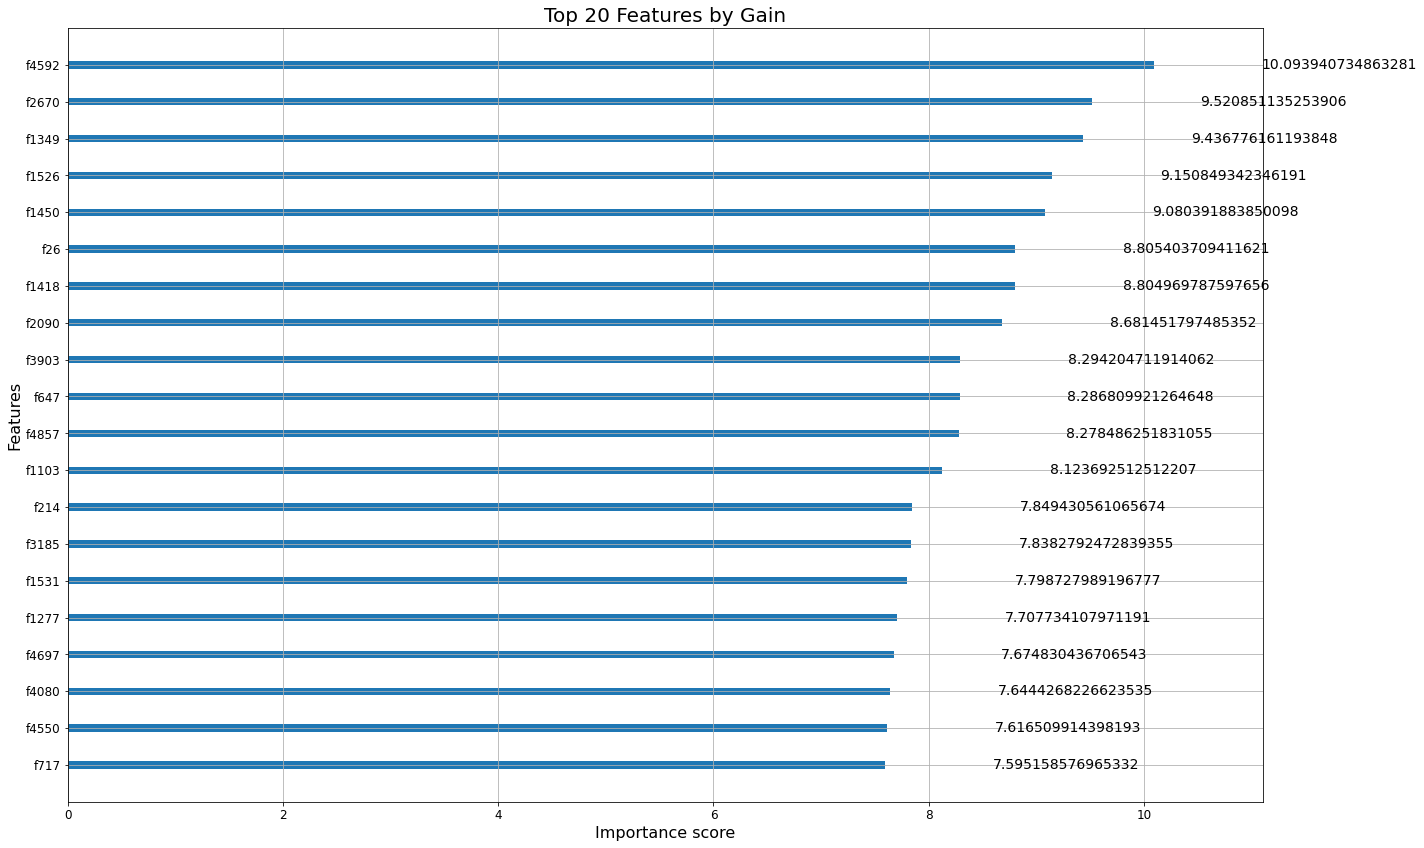

In [25]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_importance(model, max_num_features=20, importance_type='gain', ax=ax)
plt.title("Top 20 Features by Gain", fontsize=20)
plt.tight_layout()
plt.show()

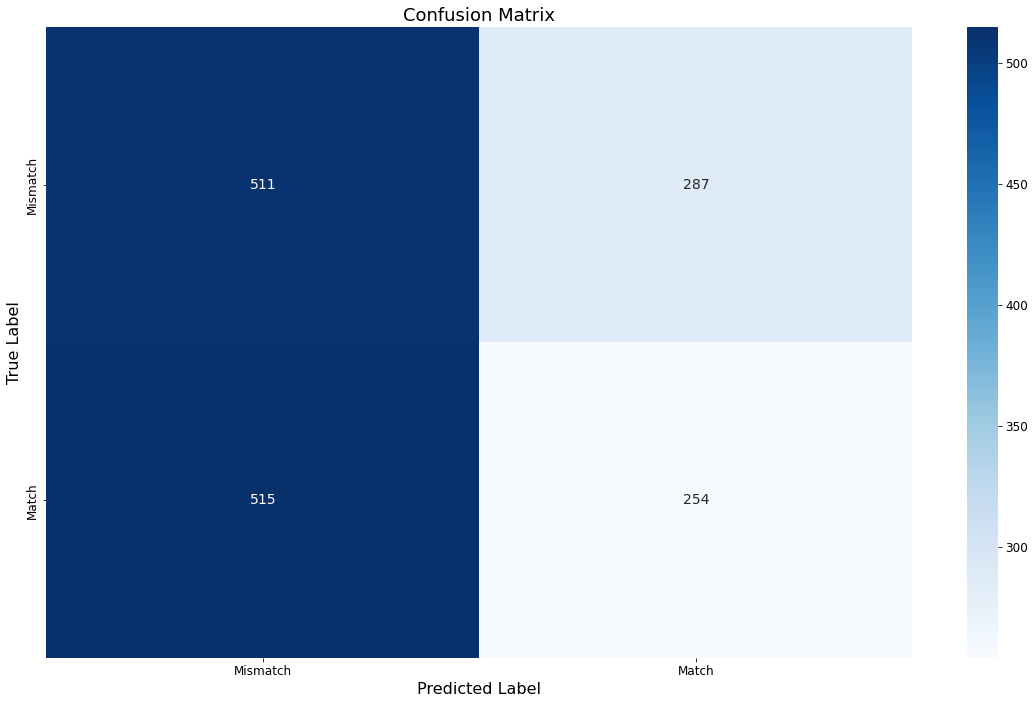

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(16, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Mismatch", "Match"], yticklabels=["Mismatch", "Match"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

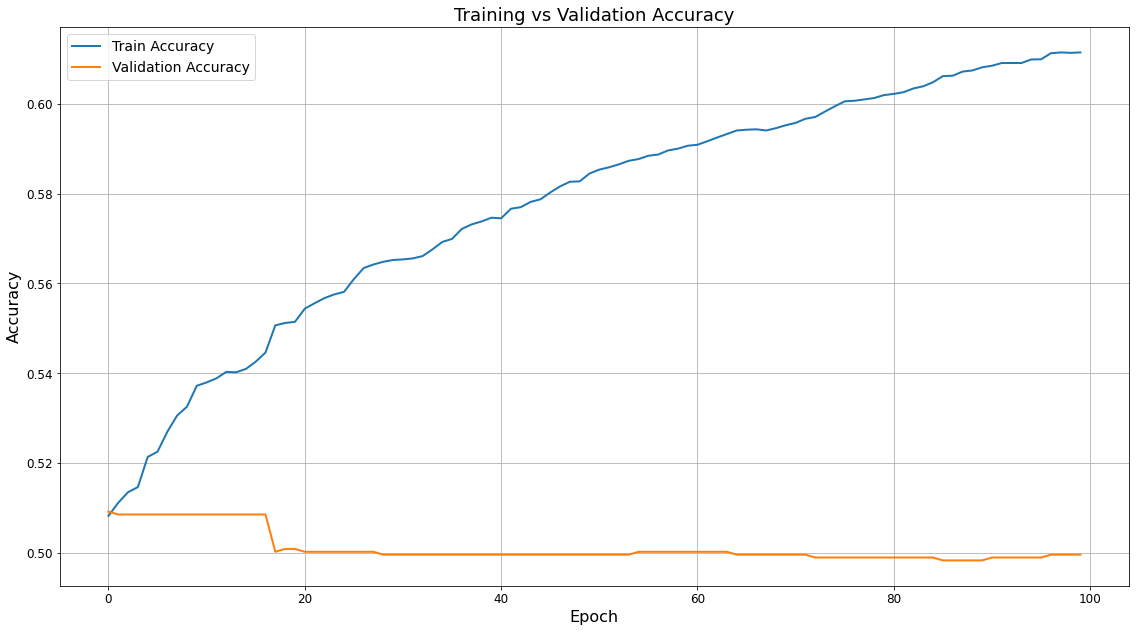

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

plt.plot(history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# TODO: Save model build after training
model.save_model("models/xgb_model.json")  # Other model formats .bst or .ubj formats

# Save as a pretrained model
# Example usage:
import xgboost as xgb

# Load pretrained model
model = xgb.XGBClassifier()
model.load_model("xgb_model.json")

# Evaluate or continue training
# model.predict(...)
# model.fit(...) with new data if needed

In [ ]:
# XGBoost GPU-build
import numpy as np
import xgboost as xgb
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import random

# Load dataset
dataset = load_dataset("deepcopy/MathWriting-human")
USE_PERCENTAGE = 0.10

train_size = int(USE_PERCENTAGE * len(dataset["train"]))
val_size = int(USE_PERCENTAGE * len(dataset["val"]))

train_data = dataset["train"].select(range(train_size))
val_data = dataset["val"].select(range(val_size))


# Binary classification task:
# 1 if image matches LaTeX, 0 if it's a random mismatch
latex_pool = train_data["latex"]

def add_label(example):
    if random.random() > 0.5:
        example["target"] = 1
        example["paired_latex"] = example["latex"]
    else:
        wrong = random.choice(latex_pool)
        while wrong == example["latex"]:
            wrong = random.choice(latex_pool)
        example["target"] = 0
        example["paired_latex"] = wrong
    return example

train_data = train_data.map(add_label)
val_data = val_data.map(add_label)

# Feature engineering
X_train = train_data["paired_latex"]
y_train = np.array(train_data["target"])
X_val = val_data["paired_latex"]
y_val = np.array(val_data["target"])

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss"
)
model.fit(X_train_vec, y_train)

# Model evals
y_pred = model.predict(X_val_vec)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred))

Results are surprising. XGBoost generalizes better as seen from the confusion matrix. Transfer learning was not implmented. Model 4 required
a lot testing and building. Feature engineering in this space is required.

In [ ]:
# end of model 4 build and test runs